<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/tf-regression-from-scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression from Scatch with TensorFlow 2

## Objectives

- how matrix multiplication is the basis of neural networks
- how loss functions work
- backpropagation
- optimizers
- regression

## Steps

1. Example: 2d: What could x and y be?
1. 
model: linear

1. 
y=mx+b where m is the slope and b is the y-intercept
2. 
m and b are the parameters
3. 
How to tune them in a way to fit the model to the data?
2. 
loss: mse as a mean of telling how far we are off, implement from scratch
3. 
Training loop, simply trying out possibilities, seeing when loss goes down

TODO

4. Is there a better way?
  * always changing by the same factor
   * how would we do this with a more complex model with more than just a few parameters?

5. 
drawing: loss in relation to m
6. 
Going down the slope of the loss
7. 
partial derivations 
8. 
How to do in tf
9. 
Optimizer



### Challenge: How do we fit the best line possible?

In [0]:
import matplotlib.pyplot as plt
# plt.xkcd()
# plt.style.use('ggplot')
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)

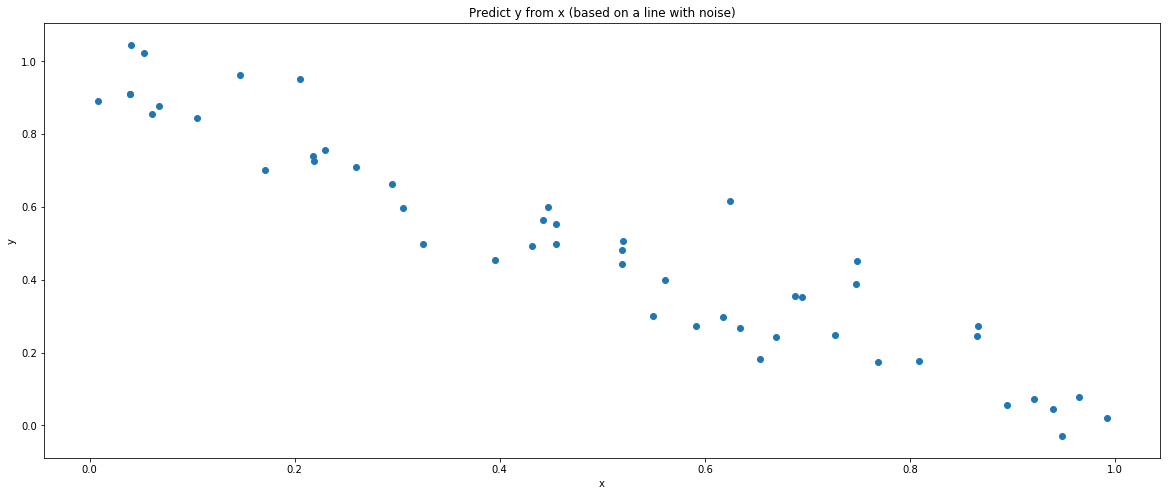

In [2]:
#@title Configure our example { display-mode: "form", run: "auto" }

# https://colab.research.google.com/notebooks/forms.ipynb

n = 120 #@param {type:"slider", min:10, max:500, step:1}
m = -1 #@param {type:"slider", min:-10, max:10, step: 0.1}
b = 1 #@param {type:"slider", min:-10, max:10, step: 0.1}

noise_level = 0.2 #@param {type:"slider", min:0.1, max:1.0, step:0.1}

title = 'Predict y from x (based on a line with noise)' #@param {type:"string"}
x_label = 'x' #@param {type:"string"}
y_label = 'y' #@param {type:"string"}

import numpy as np

a = -1
b = 1
n = 50
noise = 0.1

x = np.random.uniform(0, 1, n)
y = a*x+b + np.random.normal(0, noise, n)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

plt.scatter(x, y);

## Exercise: Get familiar with Colab notebooks and the example

* Execute all cells up to this point by pressing shift+enter in each cell
* Change the title and what is on the axis to match any application you might have
* Play with the parameters using the sliders above to get an idea of what kind of problem we are dealing with
* If the data does not match your application, adjust it in a reasonable way

## Our model: linear

### ```y = m*x + b```

* `m` is the slope 
* `b` is the y-intercept


In [0]:
class LinearModel:
  
  def __init__(self, m=0, b=0):
    self.m = m
    self.b = b
    
  def __call__(self, x):
    y = self.m * x + self.b
    return y

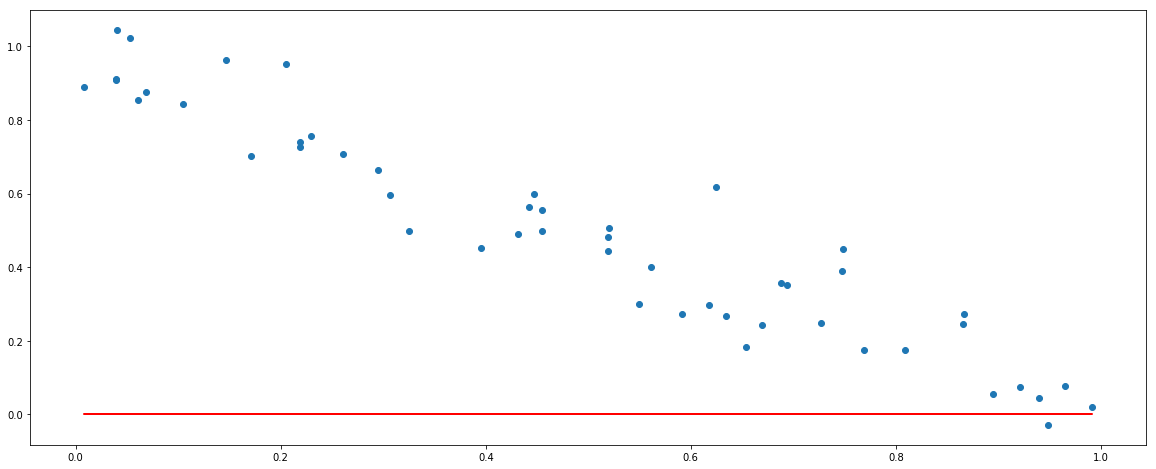

In [5]:
model = LinearModel()
y_pred = model(x)
plt.plot(x, y_pred, color='r')
plt.scatter(x, y);

## How wrong are we?
### This is obviously wrong, but how wrong are we?

In [6]:
def loss1(y_true, y_pred):
  return np.sum(y_true - y_pred)
loss1(y, y_pred)

24.741813520085504

In [7]:
def loss_no_negative(y_true, y_pred):
  return np.sum(np.abs(y_true - y_pred))
loss_no_negative(y, y_pred)

24.797823464861658

In [8]:
def loss_no_negative_normalize(y_true, y_pred):
  return np.sum(np.abs(y_true - y_pred)) / len(y_true)
loss_no_negative_normalize(y, y_pred)

0.49595646929723314

## Trying to bring the loss down in loop

### Let's begin with naive implementation

1. if we bring m or b up or down, does this improve the loss?
1. if so, do it
1. rinse and repeat for a number of times

In [9]:
model = LinearModel()

EPOCHS = 500
learning_rate = 0.01

losses = []

for step in range(EPOCHS):
  y_pred = model(x)
  
  loss = loss_no_negative_normalize(y, y_pred)
    
  # just for logging
  losses.append(loss)
  
  # let's try m
  new_model = LinearModel(m = model.m + learning_rate, b = model.b)
  new_y_pred = new_model(x)
  new_loss = loss_no_negative_normalize(y, new_y_pred)
  
  if new_loss < loss:
    model.m += learning_rate
  else:
    model.m -= learning_rate
    
  # then b
  new_model = LinearModel(m = model.m, b = model.b + learning_rate)
  new_y_pred = new_model(x)
  new_loss = loss_no_negative_normalize(y, new_y_pred)
  
  if new_loss < loss:
    model.b += learning_rate
  else:
    model.b -= learning_rate


model.m, model.b    

(-0.9400000000000006, 0.9400000000000006)

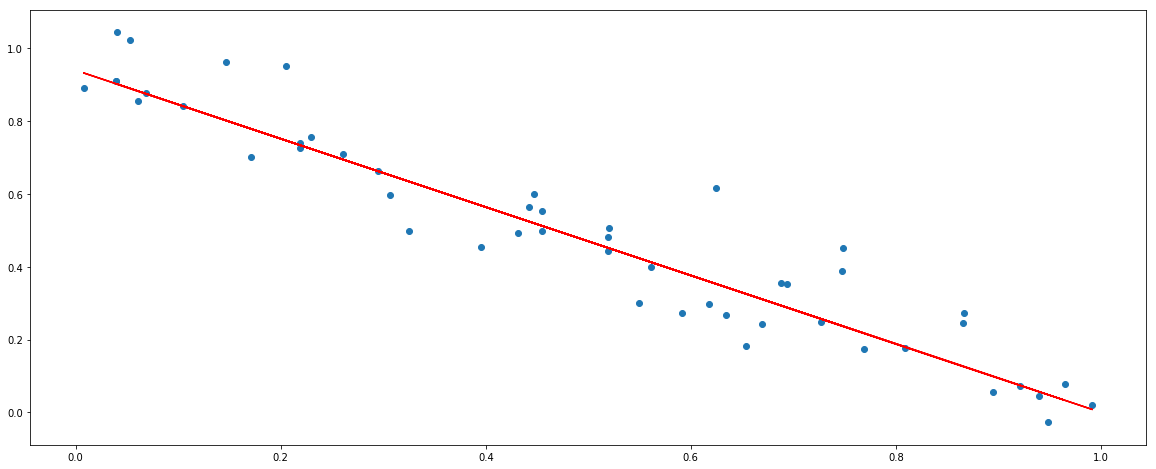

In [10]:
y_pred = model(x)
plt.plot(x, y_pred, color='r')
plt.scatter(x, y);

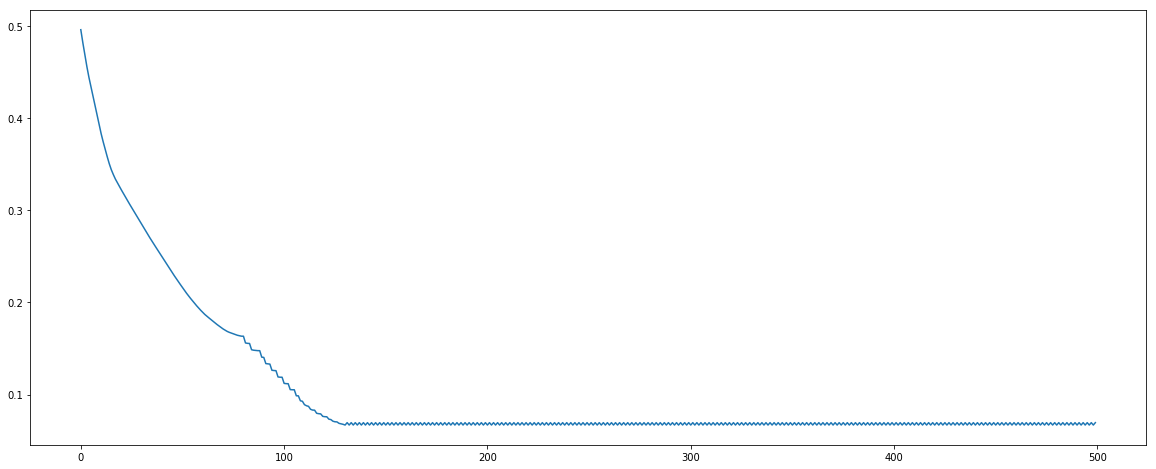

In [11]:
# plt.yscale('log')
plt.plot(losses);

## We already have a working solution

### But does this scale to an example with many more parameters and more inputs?

1. Calculating the output might be expensive
2. Trying out all parameters in a random we like we do would have a bad performance for a large problem
3. Wouldn't we also need to try them in combination?


### Let's see what we need to change for this to become a state of the art neural network using TensorFlow 2

1. Replace our model with a matrix multiplication

   * Scales well for as many neurons and inputs as we want
   * Efficient implementation on GPUs

2. Loss

3. Finding parameters to tune

4. Changing parameters